In [1]:
import jax.numpy as jnp
import numpy as np

# Special transform functions (we'll understand what these are very soon!)
from jax import grad, jit, vmap, pmap

# JAX's low level API 
# (lax is just an anagram for XLA, not completely sure how they came up with name JAX)
from jax import lax

from jax import make_jaxpr
from jax import random
from jax import device_put
import matplotlib.pyplot as plt

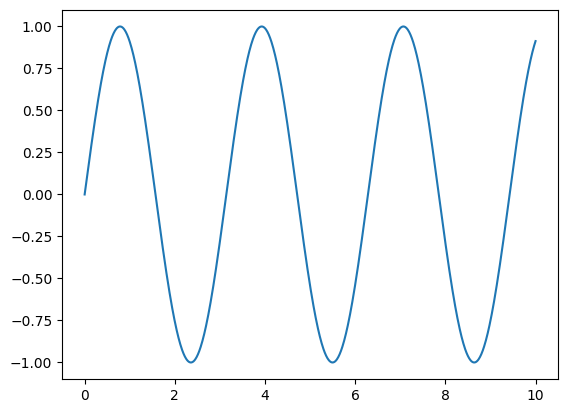

In [2]:
# Fact 1: JAX's syntax is remarkably similar to NumPy's 
x_np = np.linspace(0, 10, 1000)
y_np = 2 * np.sin(x_np) * np.cos(x_np)
plt.plot(x_np, y_np)

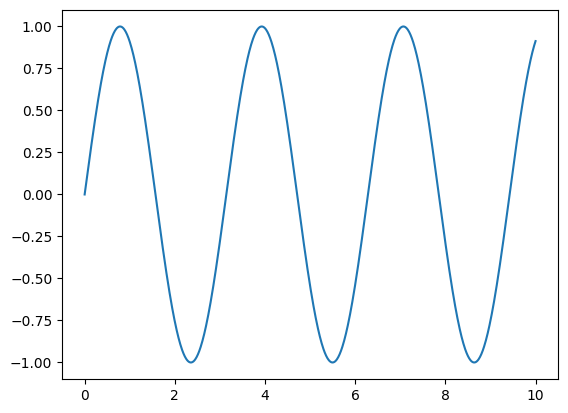

In [3]:
x_jnp = jnp.linspace(0, 10, 1000)
y_jnp = 2 * jnp.sin(x_jnp) * jnp.cos(x_jnp)
plt.plot(x_jnp, y_jnp)

In [4]:
# Fact 2: JAX arrays are immutable! (embrace the functional programming paradigm <3)

size = 10
index = 0
value = 23

# In NumPy arrays are mutable
x = np.arange(size)
print(x)
x[index] = value
print(x)

[0 1 2 3 4 5 6 7 8 9]
[23  1  2  3  4  5  6  7  8  9]


In [5]:
# In JAX we have to deal with immutable arrays
x = jnp.arange(size)
print(x)
x[index] = value
print(x)

[0 1 2 3 4 5 6 7 8 9]


TypeError: '<class 'jaxlib.xla_extension.DeviceArray'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

In [6]:
# Solution/workaround:
y = x.at[index].set(value)
print(x)
print(y)

[0 1 2 3 4 5 6 7 8 9]
[23  1  2  3  4  5  6  7  8  9]


In [7]:
# Fact 3: JAX handles random numbers differently (for a good reason! we'll see later why)
seed = 0
key = random.PRNGKey(seed)

x = random.normal(key, (10, ))  # you need to explicitly pass the key i.e. PRNG state
print(type(x), x)  # notice the DeviceArray type - that leads us to the next cell!

<class 'jaxlib.xla_extension.DeviceArray'> [-0.3721109   0.26423115 -0.18252768 -0.7368197  -0.44030377 -0.1521442
 -0.67135346 -0.5908641   0.73168886  0.5673026 ]


In [8]:
# Fact 4: JAX is AI accelerator agnostic. Same code runs everywhere!

size = 3000

# Data is automagically pushed to the AI accelerator! (DeviceArray structure)
# No more need for ".to(device)" (PyTorch syntax)
x_jnp = random.normal(key, (size, size), dtype=jnp.float32)
x_np = np.random.normal(size=(size, size)).astype(np.float32)  # some diff in API exists!

%timeit jnp.dot(x_jnp, x_jnp.T).block_until_ready()  # 1) on GPU - fast
%timeit np.dot(x_np, x_np.T)  # 2) on CPU - slow (NumPy only works with CPUs)
%timeit jnp.dot(x_np, x_np.T).block_until_ready()  # 3) on GPU with transfer overhead

x_np_device = device_put(x_np)  # push NumPy explicitly to GPU
%timeit jnp.dot(x_np_device, x_np_device.T).block_until_ready()  # same as 1)

# Note1: I'm using GPU as a synonym for AI accelerator. 
# In reality, especially in Colab, this can also be a TPU, etc.

# Note2: block_until_ready() -> asynchronous dispatch

190 ms ± 14.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
146 ms ± 8.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
169 ms ± 9.75 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
144 ms ± 5.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
# Simple helper visualization function
def visualize_fn(fn, l=-10, r=10, n=1000):
    x = np.linspace(l, r, num=n)
    y = fn(x)
    plt.plot(x, y); plt.show()

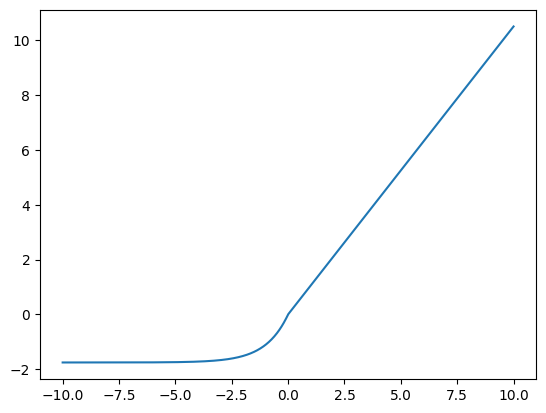

non-jit version:
6.98 ms ± 178 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
jit version:
1.09 ms ± 24 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [10]:
# Define a function
def selu(x, alpha=1.67, lmbda=1.05):  # note: SELU is an activation function
    return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

selu_jit = jit(selu)  # let's jit it

# Visualize SELU (just for your understanding, it's always a good idea to visualize stuff)
visualize_fn(selu)

# Benchmark non-jit vs jit version
data = random.normal(key, (1000000,))

print('non-jit version:')
%timeit selu(data).block_until_ready()
print('jit version:')
%timeit selu_jit(data).block_until_ready()

# Note: we'll soon see how this works (hint: jaxpr, pure functions)

In [11]:
# First example (automatic diff)

def sum_logistic(x):  # or maybe a simpler example: sum of squares? (jnp.sum(x**2))
    return jnp.sum(1.0 / (1.0 + jnp.exp(-x)))

x = jnp.arange(3.)
loss = sum_logistic  # rename it to give it some semantics

# By default grad calculates the derivative of a fn w.r.t. 1st parameter!
# Here we bundled inputs into a 1st param so it doesn't matter.
grad_loss = grad(loss)

print(grad_loss(x))

[0.25       0.19661197 0.10499357]


In [12]:
# Numeric diff (to double check that autodiff works correctly)

def finite_differences(f, x):
    eps = 1e-3
    # f(0+e, 1, 2) - f(0-e, 1, 2) / 2e
    return jnp.array([(f(x + eps * v) - f(x - eps * v)) / (2 * eps)  # derivative definition
                                for v in jnp.eye(len(x))])

print(finite_differences(loss, x))

[0.24998187 0.1965761  0.10502338]


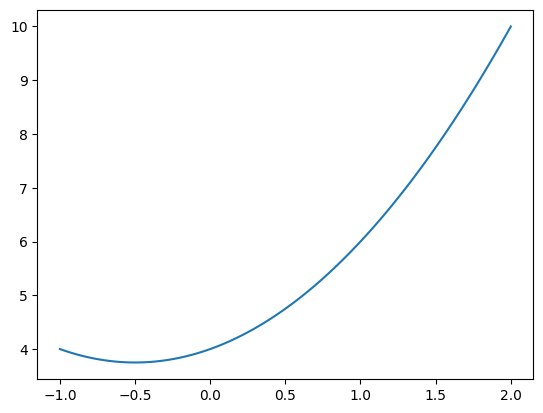

6.0 3.0 2.0 0.0


In [13]:
# Second example (automatic diff)

x = 1.  # example input

f = lambda x: x**2 + x + 4  # simple 2nd order polynomial fn
visualize_fn(f, l=-1, r=2, n=100)

dfdx = grad(f)  # 2*x + 1
d2fdx = grad(dfdx)  # 2
d3fdx = grad(d2fdx)  # 0

print(f(x), dfdx(x), d2fdx(x), d3fdx(x))

# Task: what if we had 2 inputs?

# Note1: Closer to math! 
# Note2: More powerful compared to .backward() (PyTorch syntax)

In [14]:
# JAX autodiff engine is very powerful ("advanced" example)

from jax import jacfwd, jacrev

f = lambda x, y: x**2 + y**2  # simple paraboloid (google it...)

# df/dx = 2x
# df/dy = 2y
# J = [df/dx, df/dy]

# d2f/dx = 2
# d2f/dy = 2
# d2f/dxdy = 0
# d2f/dydx = 0
# H = [[d2f/dx, d2f/dxdy], [d2f/dydx, d2f/dy]]

def hessian(f):
    return jit(jacfwd(jacrev(f, argnums=(0, 1)), argnums =(0, 1)))

print(f'Jacobian = {jacrev(f, argnums=(0, 1))(1., 1.)}')
print(f'Full Hessian = {hessian(f)(1., 1.)}')

Jacobian = (DeviceArray(2., dtype=float32, weak_type=True), DeviceArray(2., dtype=float32, weak_type=True))
Full Hessian = ((DeviceArray(2., dtype=float32, weak_type=True), DeviceArray(0., dtype=float32, weak_type=True)), (DeviceArray(0., dtype=float32, weak_type=True), DeviceArray(2., dtype=float32, weak_type=True)))


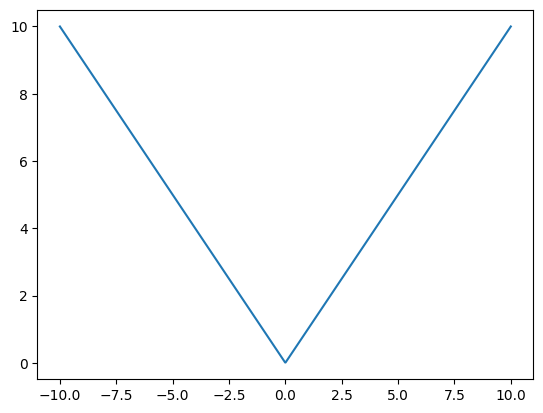

1 1
1.0


In [15]:
# Edge case |x|, how does JAX handle it?

f = lambda x: abs(x)
visualize_fn(f)

print(f(-1), f(1))
dfdx = grad(f)
print(dfdx(0.))  # play with numbers around 0 and see how JAX handles it

In [16]:
W = random.normal(key, (150, 100))  # e.g. weights of a linear NN layer
batched_x = random.normal(key, (10, 100))  # e.g. a batch of 10 flattened images

def apply_matrix(x):
    return jnp.dot(W, x)  # (150, 100) * (100, 1) -> (150, 1)

In [17]:
def naively_batched_apply_matrix(batched_x):
    return jnp.stack([apply_matrix(x) for x in batched_x])

print('Naively batched')
%timeit naively_batched_apply_matrix(batched_x).block_until_ready()

Naively batched
2.32 ms ± 122 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
@jit
def batched_apply_matrix(batched_x):
    return jnp.dot(batched_x, W.T)  # (10, 100) * (100, 150) -> (10, 150)

print('Manually batched')
%timeit batched_apply_matrix(batched_x).block_until_ready()

Manually batched
20.4 µs ± 3.83 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [19]:
@jit  # Note: we can arbitrarily compose JAX transforms! Here jit + vmap.
def vmap_batched_apply_matrix(batched_x):
    return vmap(apply_matrix)(batched_x)

# Task: modify apply_matrix to have 2 inputs and use in_axes arg

print('Auto-vectorized with vmap')
%timeit vmap_batched_apply_matrix(batched_x).block_until_ready()

Auto-vectorized with vmap
29.8 µs ± 1.21 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
